# Оптимизация параметров квантовых схем с помощью метода градиентного спуска
Мы рассмотрим, как использовать метод градиентного спуска для вычисления оптимальных параметров квантовых схем. В программе:
- Трансляция квантовых схем qiskit в pennylane
- Градиентный спуск. Как работает и почему
- Квантовые градиенты
- Градиентный спуск и метод Нестерова. Сравнение для квантовых схем

In [44]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, IBMQ
from qiskit.circuit import Parameter

# deprecated, vpn is needed: Loading your IBM Q account(s)
# provider = IBMQ.load_account()
dev = qml.device('qiskit.aer', wires=2, backend='qasm_simulator', shots=2048)

mpl.rcParams['figure.dpi'] = 150

# Что будем оптимизировать?

Генерируем состояние Белла $|\Phi+\rangle$ и действуем на первый кубит оператором $R_y$ с заранее заданным углом поворота.

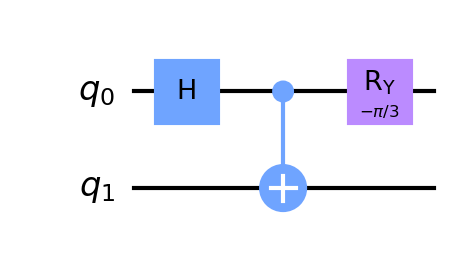

In [45]:
rotation_angle = - np.pi / 3
circuit_prep_qsk = QuantumCircuit(2)
circuit_prep_qsk.h(0)
circuit_prep_qsk.cx(0, 1)
circuit_prep_qsk.ry(rotation_angle, 0)
#circuit_prep_qsk.barrier([0,1])

circuit_prep = qml.from_qiskit(circuit_prep_qsk)
circuit_prep_qsk.draw('mpl')

Строим схему дизентанглера, чтобы подобрать угол поворота $R_y$. У схемы один параметр -- угол поворота **angle_a**.
Измеряется ожидаемое значение матрицы Паули $\langle\sigma_z\rangle$, которое равно 1 при совпадении исходного и подобранного углов.
Строится минимизируемая функция **cost**, равная $-\langle\sigma_z\rangle$. 
Её минимальное значение равно -1, что соответствует верно подобранному углу **angle_a**.
В примере решается простая оптимизационная задача без ограничений:

$$\min\:\text{cost(angle\_a)}$$

C:\Users\vonGostev\AppData\Local\Temp\ipykernel_12976\3513824171.py:18: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  (circuit_prep_qsk+circuit_meas_qsk).draw('mpl')


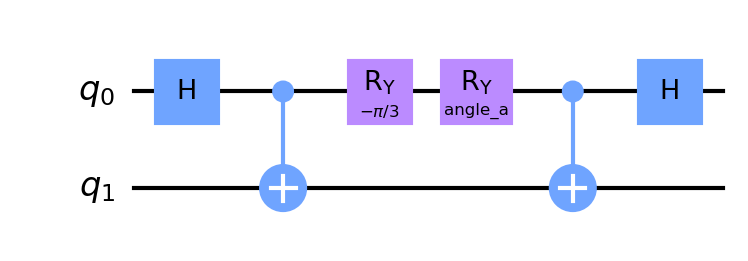

In [46]:
angle_a = Parameter("angle_a")
circuit_meas_qsk = QuantumCircuit(2)
circuit_meas_qsk.ry(angle_a, 0)
circuit_meas_qsk.cnot(0, 1)
circuit_meas_qsk.h(0)

circuit_meas = qml.from_qiskit(circuit_meas_qsk)

@qml.qnode(dev)
def bell_state_meas(angles):
    circuit_prep(wires=[0,1])
    circuit_meas({angle_a: angles[0]})#, angle_b: angles[1]})
    return qml.expval(qml.PauliZ(0))

def cost(angles):
    return -bell_state_meas(angles)

(circuit_prep_qsk+circuit_meas_qsk).draw('mpl')

# Градиентный спуск в квантовых вычислениях

### Базовый метод градиентного спуска
Прежде чем формулировать квантовый метод, вспомним сначала, как вообще строится метод градиентного спуска.
Следует сначала описать задачу, а именно: «Даны множество $\mathcal{K}$ и функция $f:\mathcal{K}\rightarrow \mathbb{R}$, требуется найти точку $x^*\in \mathcal{K}$, такую что $ f(x)\geq f(x^*)$ для всех $x\in \mathcal{K}$», что обычно записывается например вот так:

$$f(x)\rightarrow \min_{x\in \mathcal{K}}.$$

В *теории* обычно предполагается, что $f$ — дифференцируемая и выпуклая функция, а $\mathcal{K}$ — выпуклое множество (то есть все точки отрезка, проведенного между точками $x_1, x_2\in \mathcal{K}$ принадлежат $\mathcal{K}$), а еще лучше, если вообще $\mathcal{K}=\mathbb{R}^n$, это позволяет дать какие-то гарантии успешности применения градиентного спуска. На *практике* градиентный спуск успешно применяется даже когда у задачи нет ни одного из вышеперечисленных свойств.

Метод градиентного спуска построен на линейной аппроксимации целевой функции в каждой точке:

$$f(x)\approx f(x^*)+\nabla f(x^*)^T(x-x^*)$$

Чем ближе $x$ к $x^*$, чем точнее это приближение. В правой части — выражение, которое при $\nabla f(x^*)\neq 0$ может быть как больше $f(x^*)$ так и меньше. Величина $\nabla f(x^*)$ — *градиент* функции $f$ в точке $x^*$. Равенство градиента нулю означает равенство всех частных производных нулю и достижение локального экстремума.
А вот несет ли градиент какую-нибудь полезную информацию в случае, когда он отличен от нуля? 

Попробуем пока решить более простую задачу: <i>дана точка $x$, найти точку $\bar{x}$ такую, что $f(\bar{x})<f(x)$</i>. Давайте возьмем точку рядом с $x$, опять же используя линейное приближение 

$$f(\bar{x})\approx f(x)+\nabla f(x)^T(\bar{x}-x).$$

Если взять $\bar{x}=x-\alpha\nabla f(x)$, $ \alpha>0$ то мы получим

$$ f(\bar{x})\approx f(x)-\alpha\|\nabla f(x)\|^2<f(x). $$

Аналогично, если $ \alpha<0 $, то $f(\bar{x})$ будет больше $f(x)$ (здесь и далее $||x||=\sqrt{x_1^2+x_2^2+\ldots+x_n^2}~$). Опять же, так как мы использовали приближение, то эти соображения будут верны только для малых $\alpha$. Подытоживая вышесказанное, если $\nabla f(x)\neq 0$, то **градиент указывает направление наибольшего локального увеличения функции**.

Итак, мы научились по точке $x$ получать точку $\bar{x}$ с меньшим значением функции $ f$. Что мешает нам повторить это несколько раз? По сути, это и есть градиентный спуск: строим последовательность

$$ x_{k+1}=x_k-\alpha_k\nabla f(x_k). $$

Величина $\alpha_k$ называется <i>размером шага</i> (в машинном обучении — <i>скорость обучения</i>). Если $\alpha_k$ — очень маленькие, то последовательность медленно меняется, что делает алгоритм не очень эффективным; если же $\alpha_k$ очень большие, то линейное приближение становится плохим, а может даже и неверным. На практике размер шага часта подбирают эмпирически, в теории обычно предполагается липшицевость градиента, а именно, если

$$ \|\nabla f(x)-\nabla f(y)\|\leq L\|x-y\| $$

для всех $x,y$, то $\alpha_k< \frac{2}{L}$ гарантирует убывание $f(x_k)$.

Критерии остановки итерационного процесса приближенного нахождения минимума могут быть основаны на различных соображениях. Обычно используются 2:
1. $||x_{k+1}-x_{k}||\leq\epsilon$
2. $||f(x_{k+1})-f(x_{k})||\leq\epsilon$

Здеcь $x_{k}$ -- значение, полученное после k-го шага оптимизации. $\epsilon$ -- наперед заданное малое положительное число.

### Квантовый градиент
Градиент в математике определен только для классических функций. Как нам получить градиент квантовой функции? Для этого можно представить параметризованную квантовую схему как функцию $f(\theta):\mathbb{C}^n\rightarrow \mathbb{R}^m$. Для этого на выходе схемы проводятся измерения тех или иных ожидаемых значений (как в функции **bell_state_meas**, где измеряется ожидаемое значение оператора Паули $\sigma_z$ в моде 0). При таком взгляде на задачу мы можем вычислять градиент $\nabla_\theta f(\theta)$ как численно, так и, с некоторым трудом, аналитически. Эту ситуацию можно представить схематично:

<img src="https://pennylane.ai/qml/_images/quantum_gradient.png" width="40%" height="40%">

Квантовый градиент, по аналогии с обычным, также представляет собой столбец из частных производных функции:
$\vec{f}(\theta) = (f_1(\theta), f_1(\theta), ...)^T$.
Квантовый градиент может быть рассчитан на квантовом компьютере с использованием правил параметрического сдвига (parameter-shift rules). При этом, в силу линейности схем, градиент может быть рассчитан с помощью той же квантовой схемы, что и сама функция.

Подробнее см. https://pennylane.ai/qml/glossary/parameter_shift.html

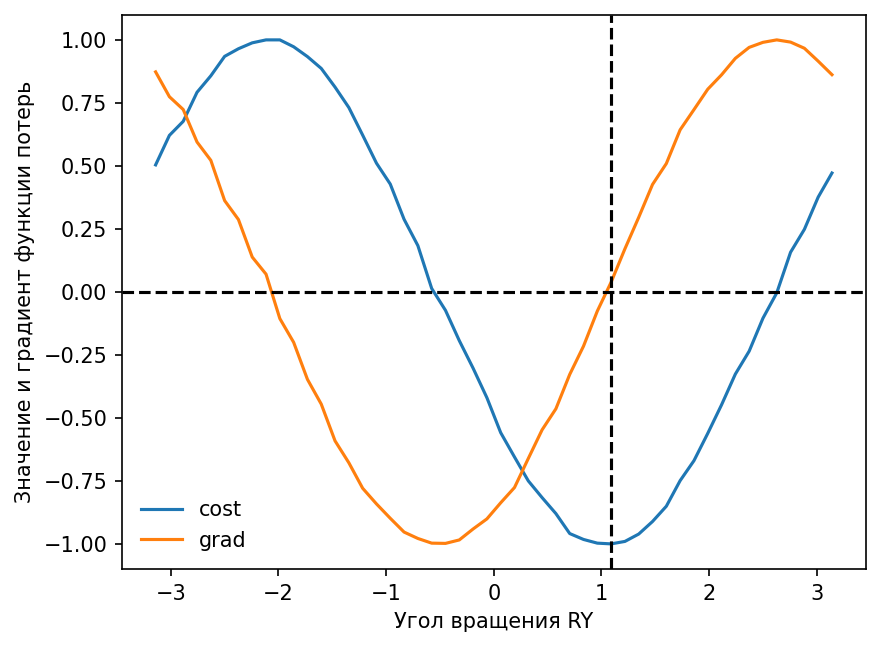

In [47]:
angles = np.linspace(-np.pi, np.pi, 50)

cost_value = lambda a: cost([a])
cost_gradient = lambda a: qml.grad(cost, argnum=(0,))([a])[0][0] # Автоматическое дифференцирование функции

cost_vals = np.vectorize(cost_value)(angles)
grad_vals = np.vectorize(cost_gradient)(angles)

lines = plt.plot(angles, cost_vals, angles, grad_vals)
plt.axvline(angles[np.argmin(cost_vals)], linestyle='--', color='black')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Угол вращения RY')
plt.ylabel('Значение и градиент функции потерь')
plt.legend(iter(lines), ('cost', 'grad'), frameon=False)
plt.show()

### Метод Нестерова
В 80х годах прошлого века Ю.Е. Нестеров придумал интересный вариант градиентного метода с накоплением импульса, который имеет вид

$$ x_{k+1}=x_k+\beta_k(x_k-x_{k-1})-\alpha_k\nabla f(x_k+\beta_k(x_k-x_{k-1})), $$
    
при этом не предполагается какого-то сложного подсчета $\alpha_k,\beta_k$. Сама по себе идея методов с накоплением импульса до очевидности проста: «Если мы некоторое время движемся в определённом направлении, то, вероятно, нам следует туда двигаться некоторое время и в будущем». В методе Нестерова помимо накопления импульса превентивно вычисляется градиент функции в "следующей" точке. Такое изменение позволяет уменьшать значение функции быстрее, если по ходу движения производная увеличивается, и медленнее, если наоборот.

Метод Нестерова является одним из наиболее популярных методов градиентного спуска для обучения нейронных сетей.

In [48]:
from time import perf_counter


opt_nesterov = qml.NesterovMomentumOptimizer(stepsize=0.1, momentum=0.9)
opt_grad = qml.GradientDescentOptimizer(stepsize=0.4)
cost_grad = qml.grad(cost)
# set the number of steps
steps = 100
# set the initial parameter values
gparams = np.array([np.pi])
nparams = np.array([np.pi])

nesterov_history = []
grad_history = []
nesterov_chistory = []
grad_chistory = []

t_start = perf_counter()
for i in range(steps):
    # update the circuit parameters
    gparams, gcost = opt_grad.step_and_cost(cost, gparams)
    nparams, ncost = opt_nesterov.step_and_cost(cost, nparams)
    
    grad_history.append(gparams[0])
    nesterov_history.append(nparams[0])
    grad_chistory.append(gcost)
    nesterov_chistory.append(ncost)
    
    if (i + 1) % 10 == 0:
        print(f"Step {i + 1:d}, time to step {(perf_counter() - t_start) / 10:.3g} s:")
        print(f"\tGradientDescent  cost={gcost:.3f} angle={nparams[0]:.3g} (pi / {np.pi / gparams[0]:.3g})")
        print(f"\tNesterovMomentum cost={ncost:.3f} angle={nparams[0]:.3g} (pi / {np.pi / nparams[0]:.3g})")
        t_start = perf_counter()
        
print(f"\nOptimized rotation angles: {gparams[0]=:.3g} {nparams[0]=:.3g}")

Step 10, time to step 0.181 s:
	GradientDescent  cost=-0.999 angle=0.493 (pi / 2.89)
	NesterovMomentum cost=-0.827 angle=0.493 (pi / 6.37)
Step 20, time to step 0.184 s:
	GradientDescent  cost=-1.000 angle=1.22 (pi / 3)
	NesterovMomentum cost=-0.979 angle=1.22 (pi / 2.57)
Step 30, time to step 0.187 s:
	GradientDescent  cost=-1.000 angle=0.979 (pi / 2.98)
	NesterovMomentum cost=-0.996 angle=0.979 (pi / 3.21)
Step 40, time to step 0.181 s:
	GradientDescent  cost=-1.000 angle=1.08 (pi / 3.05)
	NesterovMomentum cost=-0.999 angle=1.08 (pi / 2.91)
Step 50, time to step 0.201 s:
	GradientDescent  cost=-1.000 angle=1.04 (pi / 2.96)
	NesterovMomentum cost=-1.000 angle=1.04 (pi / 3.03)
Step 60, time to step 0.18 s:
	GradientDescent  cost=-1.000 angle=1.04 (pi / 3)
	NesterovMomentum cost=-1.000 angle=1.04 (pi / 3.01)
Step 70, time to step 0.192 s:
	GradientDescent  cost=-1.000 angle=1.06 (pi / 3)
	NesterovMomentum cost=-1.000 angle=1.06 (pi / 2.97)
Step 80, time to step 0.18 s:
	GradientDescent 

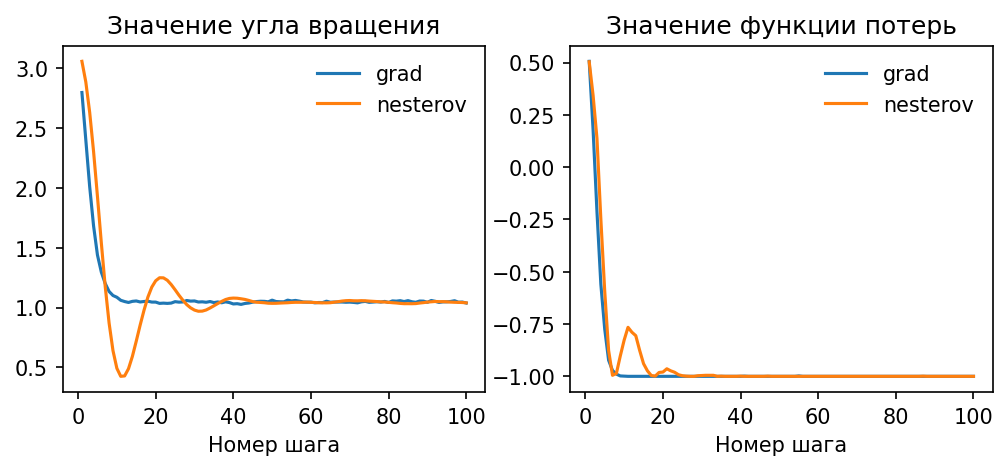

In [49]:
steps_list = np.arange(1, steps + 1)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(steps_list, grad_history, label='grad') 
ax[0].plot(steps_list, nesterov_history, label='nesterov')
ax[0].set_xlabel('Номер шага')
ax[0].set_title('Значение угла вращения')
ax[0].legend(frameon=False)

ax[1].plot(steps_list, grad_chistory, label='grad') 
ax[1].plot(steps_list, nesterov_chistory, label='nesterov')
ax[1].set_xlabel('Номер шага')
ax[1].set_title('Значение функции потерь')
ax[1].legend(frameon=False)

plt.show()

In [50]:
(gparams[0] - np.pi / 3) / (np.pi / 3)

tensor(-0.00870946, requires_grad=True)

In [51]:
(nparams[0] - np.pi / 3) / (np.pi / 3)

tensor(-0.00727168, requires_grad=True)